In [1]:
!pip install -r ../requirements.txt

import sys
sys.path.append('../src')
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import get_cmap
import math
import mplhep as hep
hep.style.use(hep.style.ATLAS)

from selectCleanEvents import *

# Configuration and Variable Declaration

In [2]:
# In data files (this can be a list if performing alignment of FPGAs, or a str if only looking at one FPGA)
# If using a list, will only output one cleaned csv file!
data_file_name = ['../analysis_files/run_287_fpga_0.csv','../analysis_files/run_287_fpga_1.csv']
pedestal_file_name='../calibrations/pedestals.csv'
mip_file_name='../calibrations/mip.csv'

# Initialize class (if you want to debug, you can look at only one bar by setting do_one_bar to True)
clean_files = selectCleanEvents(data_file_name, pedestal_file_name=pedestal_file_name, mip_file_name=mip_file_name, do_one_bar=False)

# Transform Data with Sensible Selections

To this point, we have reformatted our ROOT files into csv objects, with some minor cleaning. We have also performed calibrations for pedestal and MIP peaks. This step applies the pedestal and MIP calibrations and cleans the data. We clean the data by requiring the TOA is non-zero on both ends of the bar, and that the first layer energy is consistant with one MIP. The output csv file replaces the sum of ADC with the total number of MIPs (sum of both ends of the bar) and TOA difference (between both ends of the bar). The output is therefore per-bar/layer rather than per-end/bar/layer. The TOT is left per-end/bar/layer until a proper calibration is implemented. The clean_events() function performs the aforementioned manipulation.

In [3]:
clean_files.clean_events()

# Example Analysis on Cleaned File

In [4]:
# Load cleaned csv from previous step
muons = pd.read_csv('../analysis_files/cleaned_run287.csv')

Text(0.5, 1.0, 'Energy (MIPs) vs Layer')

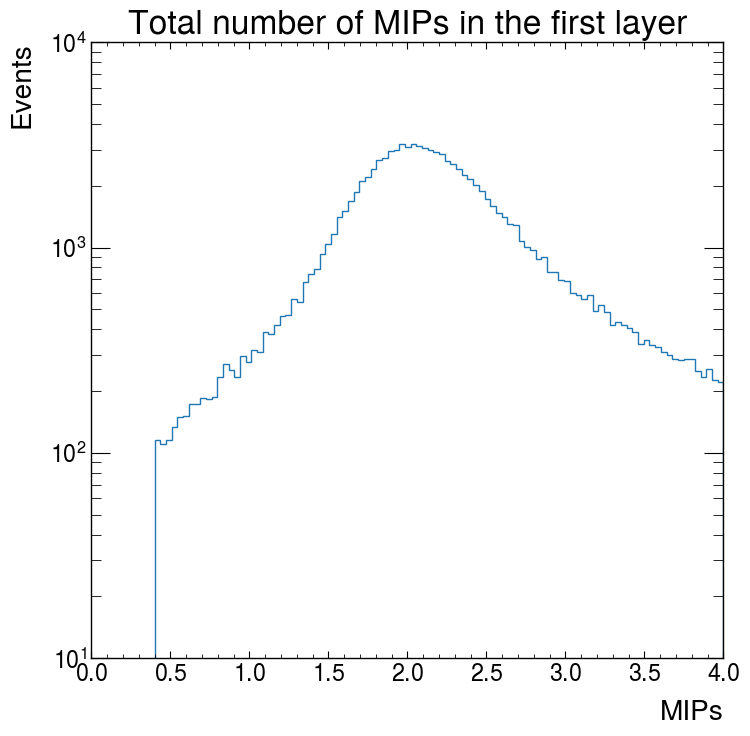

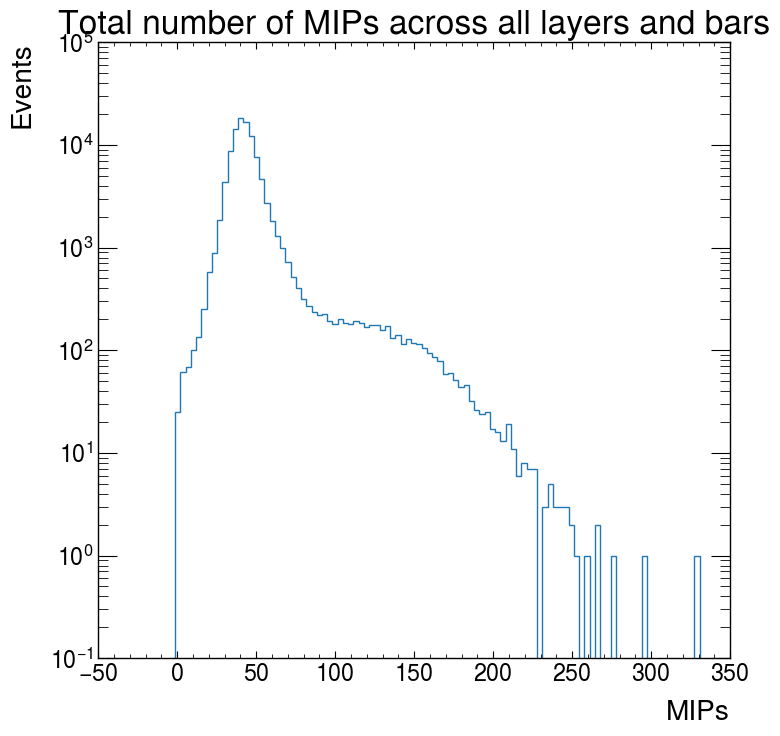

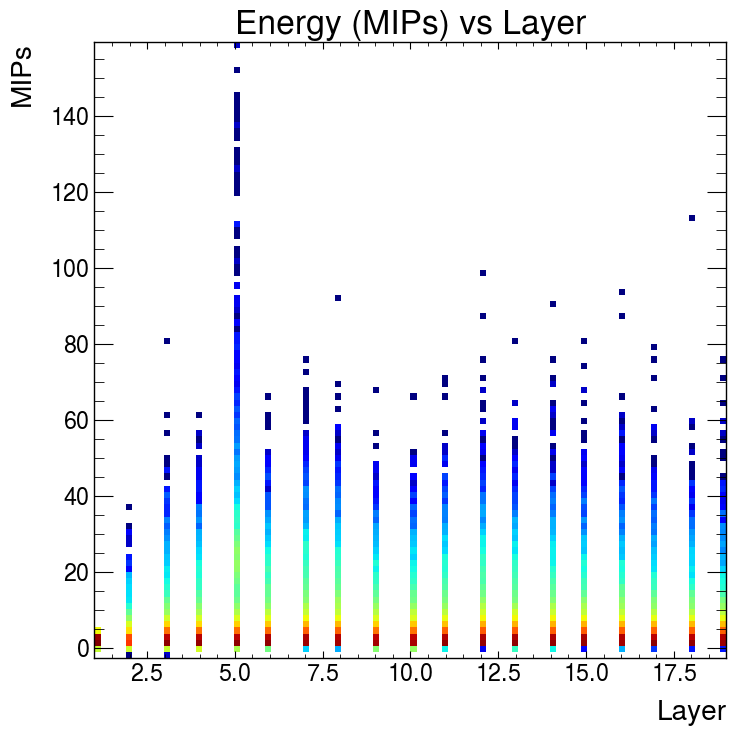

In [6]:
# Here, we calculate the total number of MIPs for each layer (across all bars) and for each event
per_event_layer = muons.groupby(['pf_event','layer'])['mips'].sum().reset_index()

# Make a histogram of the total number of MIPs in the first layer (selection is imposed in the clean_events() function such that 0.4<MIPs<4)
fig,ax = plt.subplots(figsize=(8, 8))
ax.hist(per_event_layer[per_event_layer['layer']==1]['mips'],bins=100,histtype='step')
ax.set_xlabel('MIPs')
ax.set_ylabel('Events')
ax.set_yscale('log')
ax.set_title('Total number of MIPs in the first layer')

# Here, we calculate the total number of MIPs for each event ((across all bars and layers)
per_event = muons.groupby('pf_event')['mips'].sum().reset_index()

fig,ax = plt.subplots(figsize=(8, 8))
ax.hist(per_event['mips'],bins=100,histtype='step')
ax.set_xlabel('MIPs')
ax.set_ylabel('Events')
ax.set_yscale('log')
ax.set_title('Total number of MIPs across all layers and bars')

fig,ax = plt.subplots(figsize=(8, 8))
ax.hist2d(per_event_layer['layer'],per_event_layer['mips'],bins=100,cmin=0.01,cmap='jet',norm=mcolors.LogNorm())
ax.set_xlabel('Layer')
ax.set_ylabel('MIPs')
ax.set_title('Energy (MIPs) vs Layer')

Text(0.5, 1.0, 'Energy (MIPs) vs Layer')

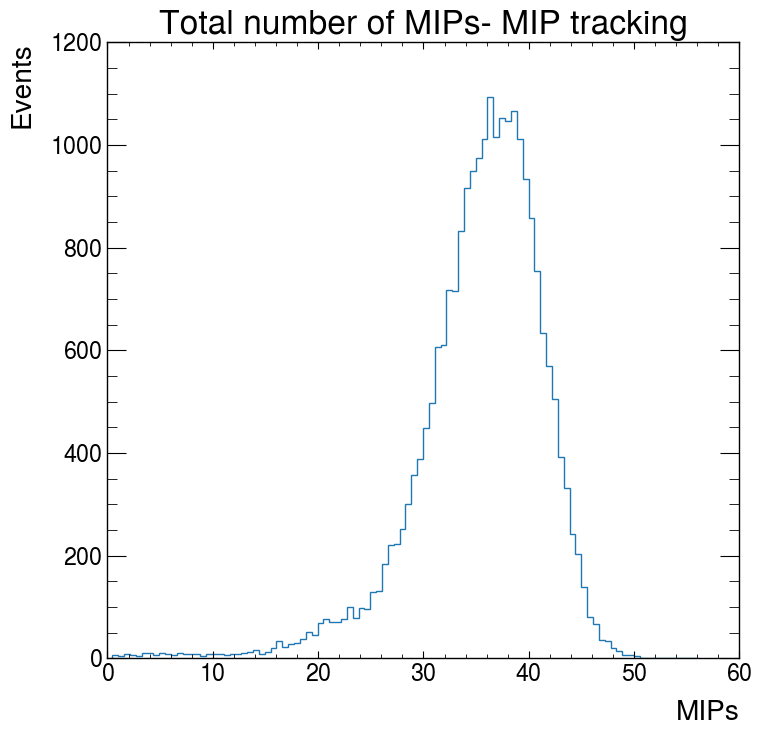

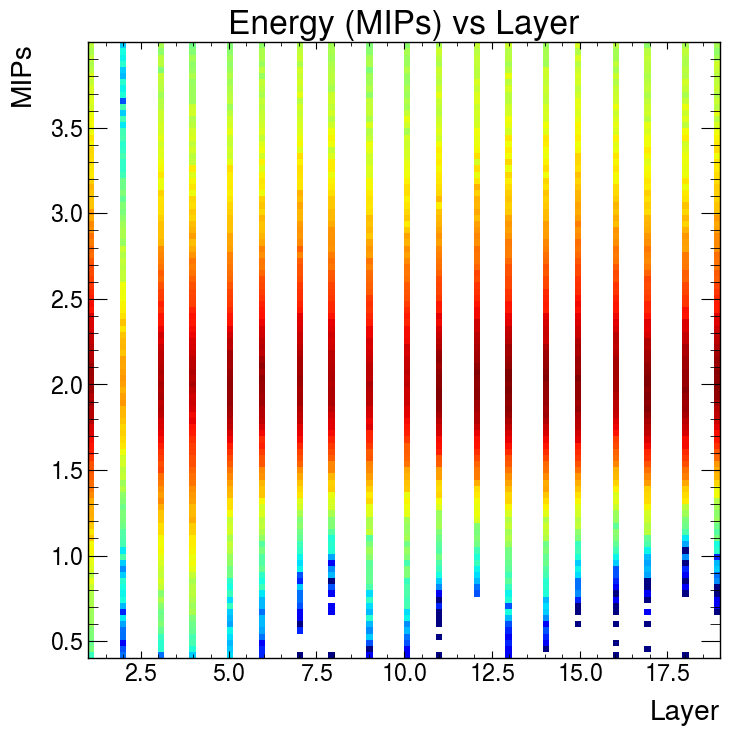

In [10]:
# Identify events where the total number of MIPs per layer is between 0.4 and 4 (extending baseline selection beyond just first layer)
# This is a low-level attempt at MIP-tracking

# Filter events where the minimum and maximum 'mips' values for each layer are within the specified range
selected_events_by_layer = (
    per_event_layer.groupby('pf_event')
    .filter(lambda group: group['mips'].between(0.4,4).all())
)['pf_event'].unique()

# Select the appropriate events
all_layers_mip = per_event_layer[per_event_layer['pf_event'].isin(selected_events_by_layer)]

# Take the total sum of MIPs across the entire HCAL for these events
sum_mip_events = all_layers_mip.groupby(['pf_event'])['mips'].sum().reset_index()

# Plot the total energy (in MIPs) deposited into the HCAL after "MIP-tracking"
fig,ax = plt.subplots(figsize=(8, 8))
ax.hist(sum_mip_events['mips'],bins=100,histtype='step')
ax.set_xlabel('MIPs')
ax.set_ylabel('Events')
ax.set_title('Total number of MIPs- MIP tracking')

# Plot the number of MIPs vs layer after "MIP-tracking"
fig,ax = plt.subplots(figsize=(8, 8))
ax.hist2d(all_layers_mip['layer'],all_layers_mip['mips'],bins=100,cmin=0.01,cmap='jet',norm=mcolors.LogNorm())
ax.set_xlabel('Layer')
ax.set_ylabel('MIPs')
ax.set_title('Energy (MIPs) vs Layer')